# Finding the Defaulters - Making the lending task easy

##### - Sidharth Purohit

Lending is one of the most important activities of the finance industry. Lenders pro‐
vide loans to borrowers in exchange for the promise of repayment with interest. That
means the lender makes a profit only if the borrower pays off the loan. Hence, the
two most critical questions in the lending industry are:

1. How risky is the borrower?
2. Given the borrower’s risk, should we lend to them?

Default prediction could be described as a perfect job for machine learning, as the
algorithms can be trained on millions of examples of consumer data. Algorithms can
perform automated tasks such as matching data records, identifying exceptions, and
calculating whether an applicant qualifies for a loan. The underlying trends can be
assessed with algorithms and continuously analyzed to detect trends that might influence lending
and underwriting risk in the future.

The goal here is to build a machine learning model to predict the probability that a loan will default.

### Problem Statement

The problem is defined in the classification framework, where the predicted variable is **“Charge-Off ”** . A charge-off is a debt that a creditor has given up trying to collect on after you’ve missed payments for several months. The predicted variable takes value 1 in case of charge-off and 0 otherwise.

This dossier aims to analyze data for loans through 2007-2017Q3 from Lending Club available on Kaggle. Dataset contains over 887 thousand observations and 150 variables among which one is describing the loan status.


### Getting Started

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')



C:\Anaconda2\envs\py36\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
loans = pd.read_csv('LoansData_sample.csv.gz', compression='gzip', encoding='utf-8')
#loans = pd.read_csv('LoansData.csv.gz', compression='gzip', low_memory=True) #Use this for the actual data

In [3]:
dataset = loans
type(dataset)

pandas.core.frame.DataFrame

In [10]:
# We're going to try to predict the loan_status variable. What are the value counts for this variable
dataset['loan_status'].value_counts(dropna=False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

We're going to try to learn differences in the features between **completed loans that have been fully paid or charged off**. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status **"Fully Paid" or "Charged Off"**.

In [14]:
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off'])]

dataset['loan_status'].value_counts(dropna=False)

dataset['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

About 81% of the remaining loans have been fully paid and 19% have charged off, so we have a somewhat unbalanced classification problem.

In [15]:
dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
dataset.drop('loan_status', axis=1, inplace=True)

We drop the loan_status completely and before dropping we keep only the charged_off status for each row. Which converts our problem to a binary classification task.

### Feature Selection-Limit the Feature Space

The full dataset has 150 features for each loan. We’ll eliminate features in following steps using three different approaches:

    Eliminate feature that have more than 30% missing values.
    Eliminate features that are unintuitive based on subjective judgement.
    Eliminate features with low correlation with the predicted variable

### Features elimination by significant missing values

First calculating the percentage of missing data for each feature:


In [18]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

total_cu_tl                            1.0
max_bal_bc                             1.0
sec_app_mort_acc                       1.0
sec_app_open_acc                       1.0
sec_app_revol_util                     1.0
sec_app_open_act_il                    1.0
sec_app_num_rev_accts                  1.0
sec_app_chargeoff_within_12_mths       1.0
sec_app_collections_12_mths_ex_med     1.0
sec_app_mths_since_last_major_derog    1.0
dtype: float64

In [19]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [20]:
len(drop_list)

58

In [21]:
dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(86138, 93)

### Features elimination based on the intutiveness

In order to filter the features further we check the description in the data dictionary and keep the features that are intuitive on the basis of subjective judgement.

We examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:


In [22]:
####The list that is kept is as follows:

keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code','last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]

len(keep_list)


40

In [23]:
drop_list = [col for col in dataset.columns if col not in keep_list]

dataset.drop(labels=drop_list, axis=1, inplace=True)

dataset.shape

(86138, 39)

### Features elimination based on the correlation

In [24]:
correlation = dataset.corr()
correlation_chargeOff = abs(correlation['charged_off'])

In [25]:
correlation_chargeOff.sort_values(ascending=False)

charged_off              1.000000
last_pymnt_amnt          0.319081
int_rate                 0.282825
dti                      0.123108
fico_range_low           0.121892
fico_range_high          0.121891
acc_open_past_24mths     0.105989
bc_open_to_buy           0.080077
bc_util                  0.077744
avg_cur_bal              0.071977
num_actv_rev_tl          0.071185
revol_util               0.066188
funded_amnt              0.060818
loan_amnt                0.060818
mort_acc                 0.057858
annual_inc               0.050349
mo_sin_old_rev_tl_op     0.049426
mo_sin_rcnt_rev_tl_op    0.048839
open_acc                 0.039430
installment              0.032847
revol_bal                0.021714
pub_rec                  0.016023
pub_rec_bankruptcies     0.015815
total_acc                0.005804
id                       0.002221
Name: charged_off, dtype: float64

In [26]:
drop_list_corr = sorted(list(correlation_chargeOff[correlation_chargeOff < 0.03].index))
print(drop_list_corr)

['id', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'total_acc']


### Feature Engineering and Exploratory Analysis


In [27]:
#Descriptive Statistics
dataset.describe()

,id,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,open_acc,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,charged_off
count,8.613800e+04,86138.000000,86138.000000,86138.000000,86138.000000,8.613800e+04,86138.000000,86138.000000,86138.000000,86138.000000,...,86138.000000,86138.000000,85142.000000,85089.000000,86138.000000,86138.000000,86138.000000,86138.000000,86138.000000,86138.000000
mean,3.021246e+07,14106.526446,14106.526446,13.002360,430.737187,7.384311e+04,18.532747,692.462966,696.463024,11.746453,...,4.594732,13066.638371,8942.506507,63.808959,183.524333,12.796896,1.748880,5.762358,0.132659,0.187559
std,4.747838e+06,8391.139221,8391.139221,4.397419,251.653139,5.929352e+04,8.538247,29.731549,29.731848,5.433122,...,3.070996,16232.739293,14100.186250,27.051347,93.266430,16.224586,2.091488,3.224598,0.381295,0.390362
min,5.716700e+04,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,660.000000,664.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.711007e+07,7800.000000,7800.000000,9.490000,248.480000,4.500000e+04,12.070000,670.000000,674.000000,8.000000,...,2.000000,3010.000000,1087.000000,44.100000,118.000000,3.000000,0.000000,3.000000,0.000000,0.000000
50%,3.040564e+07,12000.000000,12000.000000,12.990000,370.480000,6.247372e+04,17.950000,685.000000,689.000000,11.000000,...,4.000000,6994.500000,3823.000000,67.700000,167.000000,8.000000,1.000000,5.000000,0.000000,0.000000
75%,3.433371e+07,20000.000000,20000.000000,15.610000,568.005000,9.000000e+04,24.500000,705.000000,709.000000,14.000000,...,6.000000,17905.000000,10588.000000,87.500000,232.000000,15.000000,3.000000,7.000000,0.000000,0.000000
max,3.809811e+07,35000.000000,35000.000000,26.060000,1408.130000,7.500000e+06,39.990000,845.000000,850.000000,84.000000,...,53.000000,447433.000000,249625.000000,255.200000,718.000000,372.000000,34.000000,38.000000,12.000000,1.000000


In [28]:
dataset[['id','emp_title','title','zip_code']].describe()

,id
count,8.613800e+04
mean,3.021246e+07
std,4.747838e+06
min,5.716700e+04
25%,2.711007e+07
50%,3.040564e+07
75%,3.433371e+07
max,3.809811e+07


In [29]:
#Ids are all unique and there are too many job titles and titles and zipcode, 
#these column is dropped The ID is not useful for modeling.
dataset.drop(['id','emp_title','title','zip_code'], axis=1, inplace=True)

In [30]:
#Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60.". 
#The 60 Months loans are more likelely to charge off
#Convert term to integers
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))

In [31]:
dataset.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.141526
60    0.354356
Name: charged_off, dtype: float64

Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

In [32]:
dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)

def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
dataset['emp_length'] = dataset['emp_length'].apply(emp_length_to_int)

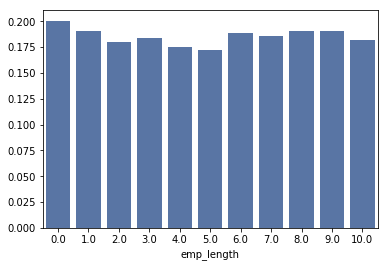

In [33]:
charge_off_rates = dataset.groupby('emp_length')['charged_off'].value_counts(normalize=True).loc[:,1]
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)

In [34]:
### Loan status does not appear to vary much with employment length on average, hence it is dropped

dataset.drop(['emp_length'], axis=1, inplace=True)

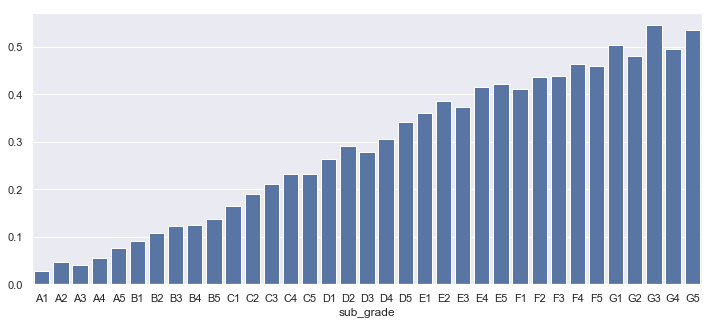

In [35]:
###Feature : Subgrade

charge_off_rates = dataset.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)



There's a clear trend of higher probability of charge-off as the subgrade worsens.

In [36]:

dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-4:]))



### Analysing the continuous features
#### Feature : Annual Income

In [38]:
dataset[['annual_inc']].describe()

,annual_inc
count,8.613800e+04
mean,7.384311e+04
std,5.929352e+04
min,4.000000e+03
25%,4.500000e+04
50%,6.247372e+04
75%,9.000000e+04
max,7.500000e+06


In [39]:


####Annual income ranges from 0 to 9,550,000, with a median of $65,000. Because of the large range of incomes, we should take a log transform of the annual income variable.


dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log10(x+1))
dataset.drop('annual_inc', axis=1, inplace=True)



In [40]:
###FICO Scores

dataset[['fico_range_low','fico_range_high']].corr()


,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


Given that the correlation between fico low and high is 1 it is preferred to keep only one feature which is average of FICO Scores

In [41]:
###Encoding Categorical Data

from sklearn.preprocessing import LabelEncoder


# Categorical boolean mask
categorical_feature_mask = dataset.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = dataset.columns[categorical_feature_mask].tolist()


categorical_cols



['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']

In [42]:
le = LabelEncoder()
# apply le on categorical feature columns
dataset[categorical_cols] = dataset[categorical_cols].apply(lambda col: le.fit_transform(col))
dataset[categorical_cols].head(10)

,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,initial_list_status,application_type
0,2,10,3,1,2,40,1,0
1,0,2,1,0,1,4,1,0
2,3,15,3,1,1,21,1,0
4,2,12,3,1,2,3,0,0
5,2,12,3,1,2,26,0,0
6,1,9,1,1,3,20,0,0
7,1,8,2,2,2,40,1,0
8,2,13,3,1,1,42,0,0
9,1,8,3,0,2,18,0,0
10,1,9,3,2,2,19,0,0


In [43]:
dataset.shape

(86138, 34)

### Sampling Data


In [44]:
loanstatus_0 = dataset[dataset["charged_off"]==0]
loanstatus_1 = dataset[dataset["charged_off"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
dataset = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
dataset = dataset.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",dataset.shape)
dataset.head()

Current shape of dataset : (11000, 34)


,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,charged_off,log_annual_inc
0,12000.0,12000.0,60,13.98,279.10,2,12,2,0,2,...,12648.0,9408.0,48.6,170.0,16.0,3.0,5.0,0.0,0,4.886496
1,13000.0,13000.0,60,8.39,266.03,0,4,1,0,2,...,3786.0,28280.0,28.8,172.0,2.0,2.0,13.0,0.0,1,4.544080
2,14000.0,14000.0,36,6.49,429.03,0,1,1,1,2,...,9760.0,35227.0,12.6,175.0,7.0,1.0,1.0,0.0,0,4.778158
3,7125.0,7125.0,36,10.99,233.23,1,7,3,0,1,...,5796.0,899.0,77.5,127.0,51.0,0.0,2.0,0.0,0,4.633479
4,4275.0,4275.0,36,15.61,149.48,3,15,1,0,2,...,4066.0,1375.0,84.0,209.0,3.0,3.0,4.0,1.0,1,4.903095


In [45]:
### Filling the NAs with the mean of the column.
dataset.fillna(dataset.mean(),inplace = True)



###  Evaluate Algorithms and Models

In [46]:
# split out validation dataset for the end
Y= dataset["charged_off"]
X = dataset.loc[:, dataset.columns != 'charged_off']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)


# dataset_temp2=dataset_temp.dropna(axis=0)
# Y_total= dataset_temp2["charged_off"]
# X_total = dataset_temp2.loc[:, dataset.columns != 'charged_off']
# X_dummy, X_validation, Y_dummy, Y_validation = train_test_split(X_total, Y_total, test_size=validation_size)


dataset['charged_off'].value_counts()




1    5500
0    5500
Name: charged_off, dtype: int64

In [47]:
# test options for classification
num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
scoring = 'roc_auc'

In [48]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [49]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.918823 (0.012300)
LDA: 0.897686 (0.015489)
KNN: 0.790186 (0.018955)
CART: 0.794645 (0.013020)
NB: 0.893579 (0.013265)
NN: 0.887216 (0.017013)
AB: 0.924851 (0.012585)
GBM: 0.935575 (0.010907)
RF: 0.903447 (0.013153)
ET: 0.876127 (0.013403)


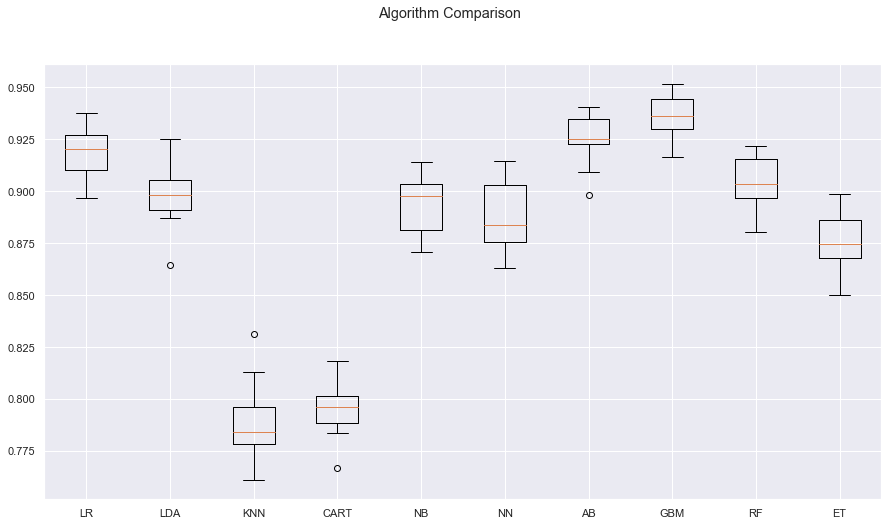

In [51]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

### Model Tuning and Grid Search

Given that the GBM is the best model, Grid Search is performed on GBM in this step.


 ### Finalise the Model

Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.

Finalize Model with best parameters found during tuning step.



In [52]:

# prepare model
model = GradientBoostingClassifier(max_depth= 5, n_estimators= 180)
model.fit(X_train, Y_train)



GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=180,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [53]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8613636363636363
[[ 867  200]
 [ 105 1028]]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1067
           1       0.84      0.91      0.87      1133

    accuracy                           0.86      2200
   macro avg       0.86      0.86      0.86      2200
weighted avg       0.86      0.86      0.86      2200



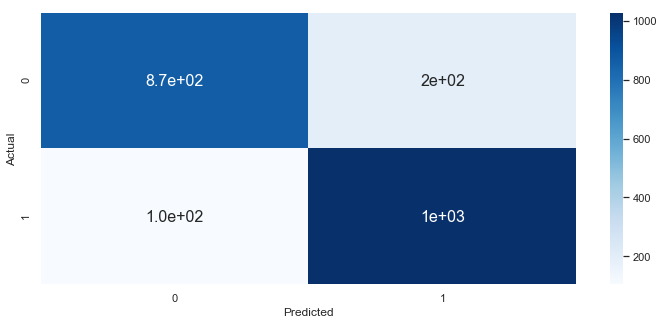

In [54]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

[0.00689724 0.00524936 0.10238726 0.05588292 0.03841699 0.00184701
 0.00568943 0.00123012 0.00382827 0.00162056 0.00508923 0.01082276
 0.00612946 0.00347069 0.0027796  0.00414127 0.00094299 0.00957477
 0.00863523 0.00588557 0.00113069 0.64359869 0.         0.01245469
 0.01168201 0.01091505 0.00656177 0.01081535 0.00718121 0.00342336
 0.0029456  0.00064868 0.00812218]


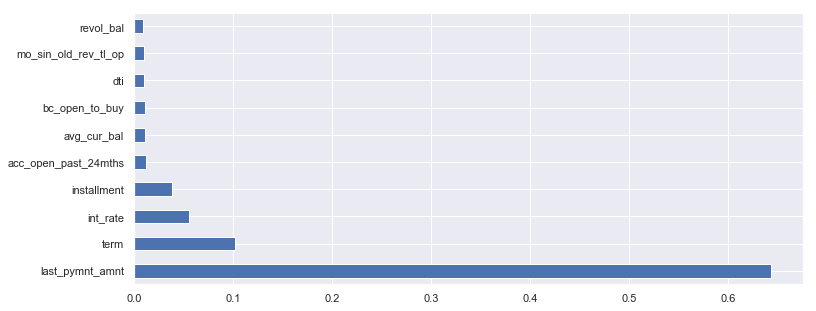

In [55]:
###Variable Intuition/Feature Importance

###Looking at the details above GBM might be worthy of further study. Let us look into the Feature Importance of the GBM model

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()



### Conclusion:

We showed that data preparation is one of the most important steps. We addressed that by performing feature elimination by using different techniques such as subjective judgement, correlation, visualization and the data quality of the feature. We illustrated that there can be different ways of handling and analyzing the categorical data and converting categorical data into model usable format.

Finally, we analyzed the feature importance and found that results of the case study are quite intuitive.
